In [5]:
from matplotlib import pyplot as plt
import cv2
import json
import os
import pandas as pd
import sklearn.metrics
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

In [6]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [7]:
def compute_iou(pred_list, gt_list):
    # load the image
    #image = cv2.imread(image_path)
    # define the top-left and bottom-right coordinates of ground-truth
    # and prediction
    groundTruth = gt_list
    prediction = pred_list

    # compute the intersection over union and display it
    iou = intersection_over_union(groundTruth, prediction)
    
    return iou

In [8]:
pred = open('predictions.json')
predictions = json.load(pred)
gt = open('ground_truth.json')
ground_truth = json.load(gt)

pred_list = []
gt_list = []

for x in predictions:
    pred_list.append(x[3:])

for y in ground_truth:
    gt_list.append(y[3:])


compute_iou(pred_list, gt_list)

0.0

In [9]:
prediction = pd.read_csv('test_data/jNQXAC9IVRw_0_3_export_data.csv')
ground_truth = pd.read_csv('test_data/ground_truth.csv')
prediction['split'] = 'prediction'
ground_truth['split'] = 'ground_truth'

df = pd.merge(ground_truth, prediction, on='image_name')
df.head(10)

,Unnamed: 0_x,label_name_x,bbox_x1_x,bbox_y1_x,bbox_x2_x,bbox_y2_x,image_name,width_x,height_x,split_x,Unnamed: 0_y,label_name_y,bbox_x1_y,bbox_y1_y,bbox_x2_y,bbox_y2_y,width_y,height_y,confidence,split_y
0,0,non_uniformed,92,39,320,240,000000.jpg,320,240,ground_truth,0,non_uniformed,85,22,308,240,320,240,0.931403,prediction
1,1,non_uniformed,92,38,320,240,000001.jpg,320,240,ground_truth,1,non_uniformed,97,26,311,240,320,240,0.951895,prediction
2,2,non_uniformed,93,39,320,240,000002.jpg,320,240,ground_truth,2,non_uniformed,90,23,306,240,320,240,0.865422,prediction
3,3,non_uniformed,93,39,320,240,000003.jpg,320,240,ground_truth,3,non_uniformed,97,25,303,240,320,240,0.836643,prediction
4,4,non_uniformed,92,40,320,240,000004.jpg,320,240,ground_truth,4,non_uniformed,99,26,302,240,320,240,0.781357,prediction
5,4,non_uniformed,92,40,320,240,000004.jpg,320,240,ground_truth,5,non_uniformed,246,31,280,140,320,240,0.527432,prediction
6,5,non_uniformed,90,39,320,240,000005.jpg,320,240,ground_truth,6,non_uniformed,99,25,305,240,320,240,0.762788,prediction
7,6,non_uniformed,88,38,320,240,000006.jpg,320,240,ground_truth,7,non_uniformed,82,28,302,240,320,240,0.804443,prediction
8,7,non_uniformed,89,35,320,240,000007.jpg,320,240,ground_truth,8,non_uniformed,95,25,309,240,320,240,0.893429,prediction
9,8,non_uniformed,89,35,320,240,000008.jpg,320,240,ground_truth,9,non_uniformed,89,28,315,240,320,240,0.940327,prediction


In [10]:
iou = []

for index, row in df.iterrows():

    pred_list = [row['bbox_x1_y'], row['bbox_y1_y'], row['bbox_x2_y'], row['bbox_y2_y']]
    gt_list = [row['bbox_x1_x'], row['bbox_y1_x'], row['bbox_x2_x'], row['bbox_y2_x']]

    iou.append({
        'gt_index': row['Unnamed: 0_x'],
        'image_name': row['image_name'],
        'ground truth_label': row['label_name_x'],
        'prediction_label': row['label_name_y'],
        'confidence_score': row['confidence'],
        'iou': compute_iou(pred_list, gt_list)
    })

In [11]:
df = pd.DataFrame(iou)
df = df.sort_values(by=['confidence_score'], ascending=False)
df['tp'] = 0
df['fp'] = 0

In [12]:
iou_threshold = 0.5

In [13]:
df.loc[df['iou'] >= iou_threshold, 'tp'] = 1
df.loc[df['iou'] < iou_threshold, 'fp'] = 1
df.loc[df['prediction_label'] != df['ground truth_label'], 'fp'] = 1
df['acc_tp'] = df['tp'].cumsum()
df['acc_fp'] = df['fp'].cumsum()
df['precision'] = df['acc_tp'] / (df['acc_tp'] + df['acc_fp'])
df['recall'] = df['acc_tp'] / len(ground_truth)

In [14]:
df.tail(20)

,gt_index,image_name,ground truth_label,prediction_label,confidence_score,iou,tp,fp,acc_tp,acc_fp,precision,recall
25,14,000014.jpg,non_uniformed,non_uniformed,0.599198,0.118226,0,1,45,32,0.584416,1.0
95,44,000044.jpg,non_uniformed,non_uniformed,0.595516,0.141676,0,1,45,33,0.576923,1.0
15,10,000010.jpg,non_uniformed,non_uniformed,0.594778,0.078464,0,1,45,34,0.569620,1.0
87,39,000039.jpg,non_uniformed,non_uniformed,0.591401,0.094554,0,1,45,35,0.562500,1.0
85,38,000038.jpg,non_uniformed,non_uniformed,0.591337,0.131307,0,1,45,36,0.555556,1.0
80,36,000036.jpg,non_uniformed,non_uniformed,0.591213,0.132669,0,1,45,37,0.548780,1.0
12,9,000009.jpg,non_uniformed,non_uniformed,0.581470,0.077801,0,1,45,38,0.542169,1.0
74,34,000034.jpg,non_uniformed,non_uniformed,0.579423,0.095454,0,1,45,39,0.535714,1.0
33,17,000017.jpg,non_uniformed,non_uniformed,0.567178,0.105884,0,1,45,40,0.529412,1.0
18,11,000011.jpg,non_uniformed,non_uniformed,0.550986,0.127976,0,1,45,41,0.523256,1.0


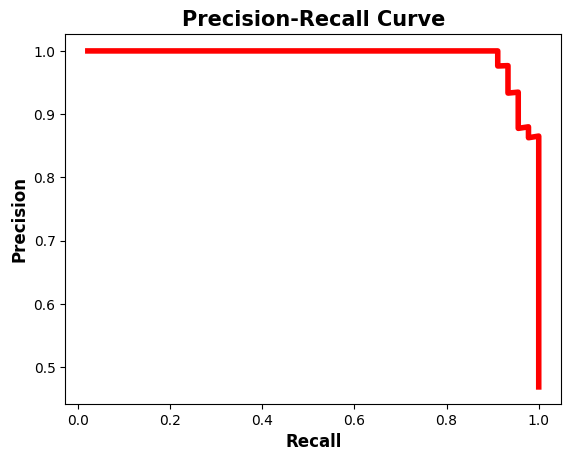

In [329]:
plt.plot(list(df['recall']), list(df['precision']), linewidth=4, color="red")
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
#plt.savefig(path)
plt.show()

In [334]:
with open('ground_truth.json') as gt:
    ground_truth = json.load(gt)

with open('predictions.json') as pred:
    predictions = json.load(pred)

In [335]:
ground_truth

{'info': {'description': 'test'},
 'image': [{'id': 0, 'width': 320, 'height': 240, 'file_name': '000000.jpg'},
  {'id': 1, 'width': 320, 'height': 240, 'file_name': '000001.jpg'},
  {'id': 2, 'width': 320, 'height': 240, 'file_name': '000002.jpg'},
  {'id': 3, 'width': 320, 'height': 240, 'file_name': '000003.jpg'},
  {'id': 4, 'width': 320, 'height': 240, 'file_name': '000004.jpg'},
  {'id': 5, 'width': 320, 'height': 240, 'file_name': '000005.jpg'},
  {'id': 6, 'width': 320, 'height': 240, 'file_name': '000006.jpg'},
  {'id': 7, 'width': 320, 'height': 240, 'file_name': '000007.jpg'},
  {'id': 8, 'width': 320, 'height': 240, 'file_name': '000008.jpg'},
  {'id': 9, 'width': 320, 'height': 240, 'file_name': '000009.jpg'},
  {'id': 10, 'width': 320, 'height': 240, 'file_name': '000010.jpg'},
  {'id': 11, 'width': 320, 'height': 240, 'file_name': '000011.jpg'},
  {'id': 12, 'width': 320, 'height': 240, 'file_name': '000012.jpg'},
  {'id': 13, 'width': 320, 'height': 240, 'file_name': '0

In [353]:
coco_gt = COCO('ground_truth.json')
coco_pred = COCO('predictions.json')
imgIds = sorted(coco_gt.getImgIds())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...


AssertionError: annotation file format <class 'list'> not supported

In [351]:
cocoEval = COCOeval(coco_gt, coco_pred, "bbox")
cocoEval.params.imgIds = imgIds 


In [352]:
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1